**Análisis espacial de los usuarios asignados a la Subred Sur de Salud en Bogotá mediante técnicas de programación**


En el siguiente código, usted encontrará los pasos para realizar un análisis espacial a partir de datos alfanuméricos, se tomará como ejemplo, los datos de los usuarios asignados a la Subred Integral de Servicios de Salud Sur para el mes de enero del año 2025 de la ciudad de Bogotá donde se harán operaciones espaciales entre archivos vector y ráster.


**Paso 1-- Cargar las liberias a utilizar**

In [31]:
import geopandas as gpd
import pandas as pd
from scipy.spatial import cKDTree
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import Point
import os






**NOTA** 

Si se desea se pueden importar más librerías en el transcurso del código 


**Paso 2-- Cargar los datos de usuarios asignados**

Se importan los datos al código, en este caso los usuarios asignados a la Subred de Servicios de Salud Sur para enero de 2025, asegurando que se tengan las coordenadas disponibles


In [35]:
ruta_usuarios_subred_sur = ruta_usuarios_subred_sur = r'C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\usuarios_asignados_subred_sur_enero_2025.csv'
# Cargar el archivo con los datos
usuarios_subred_sur = pd.read_csv(ruta_usuarios_subred_sur, sep=";")

# Ver las 5 primeras filas
print(usuarios_subred_sur.head())




   ID          X         Y  EDAD SEXO ASEGURAMIENTO
0   1 -74.128344  4.568888    50    F   SUBSIDIADO 
1   2 -74.128344  4.568888    19    M   SUBSIDIADO 
2   3 -74.128344  4.568888    23    M   SUBSIDIADO 
3   4 -74.171004  4.591763    34    F   SUBSIDIADO 
4   5 -74.106723  4.496200    25    M   SUBSIDIADO 


**NOTA**

En esta ocasión, las coordenadas (`X` y `Y`) están separadas por comas (`,`) en lugar de puntos (`.`).  
Esto puede generar problemas al procesar los datos en Python, ya que las comas pueden ser interpretadas como texto en lugar de valores numéricos.  

Para evitar errores, se debe especificar en el código que las comas representan decimales y convertir las coordenadas a valores numéricos (`float`), asegurando su correcto procesamiento en los análisis espaciales.  


In [37]:
ruta_usuarios_subred_sur = r'C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\usuarios_asignados_subred_sur_enero_2025.csv'

# Cargar el archivo, especificando el separador y reemplazando comas por puntos en las coordenadas
usuarios_subred_sur = pd.read_csv(ruta_usuarios_subred_sur, sep=";", decimal=",")

# Convertir las coordenadas a tipo numérico
usuarios_subred_sur["X"] = usuarios_subred_sur["X"].astype(float)
usuarios_subred_sur["Y"] = usuarios_subred_sur["Y"].astype(float)

# Ver las primeras filas
print(usuarios_subred_sur.head())

#El archivo original que quede con ese cambio 
usuarios_subred_sur.to_csv(ruta_usuarios_subred_sur, sep=";", index=False)


   ID          X         Y  EDAD SEXO ASEGURAMIENTO
0   1 -74.128344  4.568888    50    F   SUBSIDIADO 
1   2 -74.128344  4.568888    19    M   SUBSIDIADO 
2   3 -74.128344  4.568888    23    M   SUBSIDIADO 
3   4 -74.171004  4.591763    34    F   SUBSIDIADO 
4   5 -74.106723  4.496200    25    M   SUBSIDIADO 


**Paso 3--Dataframe a un Geodataframe**

Ahora, para visualizar los puntos de los usuarios asignados, se le asigna una columna de geometría a los datos que se subieron. Este paso convierte el DataFrame en un GeoDataFrame, lo que permitirá trabajar con las geometrías de forma eficiente 

In [39]:
# Convertir el DataFrame en un GeoDataFrame
usuarios_subred_sur_geo = gpd.GeoDataFrame(
    usuarios_subred_sur,
    geometry=gpd.points_from_xy(usuarios_subred_sur["X"], usuarios_subred_sur["Y"]),
    crs="EPSG:4326"  
)

# Acortar los nombres de las columnas que sean mayores a 10 caracteres
usuarios_subred_sur_geo.columns = [col[:10] for col in usuarios_subred_sur_geo.columns]

# Mostrar las primeras filas con la nueva columna de geometría
print(usuarios_subred_sur_geo.head())

# Guardar el GeoDataFrame de los usuarios asignados en un shapefile
usuarios_subred_sur_geo.to_file(r'C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\usuarios_subred_sur_geo.shp')


   ID          X         Y  EDAD SEXO   ASEGURAMIE                   geometry
0   1 -74.128344  4.568888    50    F  SUBSIDIADO   POINT (-74.12834 4.56889)
1   2 -74.128344  4.568888    19    M  SUBSIDIADO   POINT (-74.12834 4.56889)
2   3 -74.128344  4.568888    23    M  SUBSIDIADO   POINT (-74.12834 4.56889)
3   4 -74.171004  4.591763    34    F  SUBSIDIADO     POINT (-74.171 4.59176)
4   5 -74.106723  4.496200    25    M  SUBSIDIADO    POINT (-74.10672 4.4962)


**PASO 4-- Incluir capas poligonales**

Ya con los puntos con una geometría establecida, se procederá a ubicarlos en un contexto espacial. Para ello, se incluirá una capa poligonal que representa la ciudad de Bogotá dividida por localidades.



    

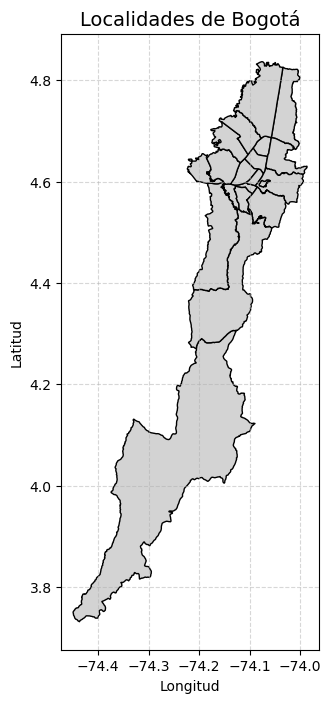

In [62]:
# Cargar la capa poligonal de las localidades de Bogotá
ruta_localidades = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\Loca.shp"
localidades_bogota = gpd.read_file(ruta_localidades)

# Convertir a una proyección adecuada
localidades_bogota = localidades_bogota.to_crs(epsg=4326)  

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar localidades de Bogotá
localidades_bogota.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1)

# Personalizar el gráfico
ax.set_title("Localidades de Bogotá", fontsize=14)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(True, linestyle="--", alpha=0.5)  # Agregar cuadrícula para referencia

# Guardar el mapa en la carpeta de resultados
ruta_guardado = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\results\localidades_bogota.png"
plt.savefig(ruta_guardado, dpi=300, bbox_inches='tight')

# Mostrar el mapa
plt.show()



**Nota**

En este análisis se usará esta capa de localidades , no obstante en la ciudad de Bogotá , tambien se pueden añadir capas como UPZ(Unidad de planeamiento zonal) , UPR(Unidad de planeamiento rural), sectores castastrales , barrios segun la delimitación territorial deseada

**Paso-- 5 Unión espacial de los puntos de usuarios asignados y las localidades de Bogotá** 

En esta sección del código, se procederá a realizar la unión espacial de los puntos correspondientes a los usuarios asignados y las localidades de Bogotá, con el fin de determinar en qué localidad se encuentra cada usuario según sus coordenadas. Para ello, se utilizará la función .sjoin de GeoPandas, que permitirá combinar los datos espaciales de los usuarios con las localidades. Posteriormente, se mostrará un mapa inicial que visualizará la ubicación de los puntos de los usuarios dentro de las localidades correspondientes.

CRS de usuarios: EPSG:4326
CRS de localidades: EPSG:4326
   ID          X         Y  EDAD SEXO   ASEGURAMIE                   geometry  \
0   1 -74.128344  4.568888    50    F  SUBSIDIADO   POINT (-74.12834 4.56889)   
1   2 -74.128344  4.568888    19    M  SUBSIDIADO   POINT (-74.12834 4.56889)   
2   3 -74.128344  4.568888    23    M  SUBSIDIADO   POINT (-74.12834 4.56889)   
3   4 -74.171004  4.591763    34    F  SUBSIDIADO     POINT (-74.171 4.59176)   
4   5 -74.106723  4.496200    25    M  SUBSIDIADO    POINT (-74.10672 4.4962)   

   index_right       LocNombre           LocAAdmini       LocArea LocCodigo  \
0            1      TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
1            1      TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
2            1      TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
3           14  CIUDAD BOLIVAR   Acuerdo 14 de 1983  1.300026e+08        19   
4           13            USME   Acuerdo 15 de 1993  2.150667

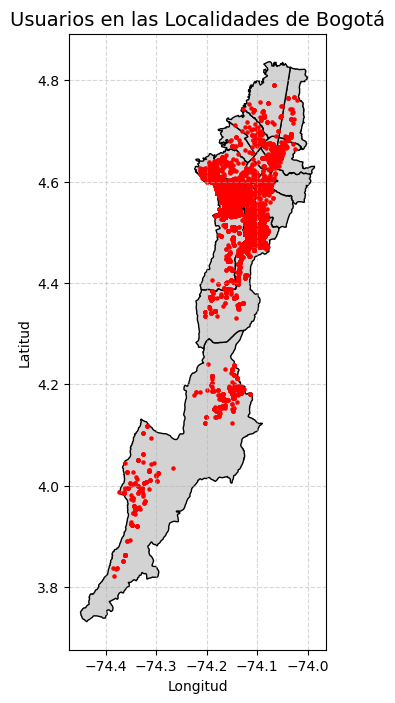

In [66]:
# Asegurar que ambos GeoDataFrames tengan el mismo CRS
usuarios_subred_sur_geo = usuarios_subred_sur_geo.to_crs(epsg=4326)  # Convertir a EPSG:4326

# Verificar que ahora ambos tienen el mismo CRS
print(f"CRS de usuarios: {usuarios_subred_sur_geo.crs}")
print(f"CRS de localidades: {localidades_bogota.crs}")

# Realizar la unión espacial
usuarios_localidades = gpd.sjoin(usuarios_subred_sur_geo, localidades_bogota, how="inner", predicate="within")

# Verificar si la unión tiene datos
if usuarios_localidades.empty:
    print("⚠️ Advertencia: No hay usuarios dentro de las localidades después de la unión espacial.")
else:
    print(usuarios_localidades.head())

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar localidades de Bogotá
localidades_bogota.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1)

# Graficar los puntos de usuarios dentro de las localidades si hay datos
if not usuarios_localidades.empty:
    usuarios_localidades.plot(ax=ax, color='red', markersize=5)

# Personalizar el gráfico
ax.set_title("Usuarios en las Localidades de Bogotá", fontsize=14)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(True, linestyle="--", alpha=0.5)

# Guardar el mapa como archivo de imagen en la carpeta results
ruta_guardado = r'C:/MAESTRIA_EN_GEOMATICA/Programacion_SIG/PROYECTO_FINAL_CODIGO/Analisis_Espacial/results/usuarios_localidades_bogota.png'
plt.savefig(ruta_guardado, dpi=300, bbox_inches="tight")

# Mostrar el mapa
plt.show()


**NOTA**

Se guardará el archivo resultante de la unión entre los usuarios asignados en un Geopackage  


In [69]:
# Guardar resultado en formato GeoPackage (más eficiente que Shapefile)
usuarios_localidades.to_file(r'C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\usuarios_localidades_union.gpkg', driver="GPKG")




**Paso 6 -- Conteo y filtrado de usuarios en la Subred Sur**

En este paso, se realizará un conteo de los usuarios asignados dentro del territorio de la Subred Sur, es decir, aquellos ubicados en las localidades de Usme, Tunjuelito, Ciudad Bolívar y Sumapaz.

Además, se aplicará un filtro para seleccionar únicamente los usuarios que pertenezcan a estas localidades, asegurando que el análisis se enfoque en la zona de interés.

In [85]:
# Eliminar espacios adicionales en los nombres de las localidades
usuarios_localidades["LocNombre"] = usuarios_localidades["LocNombre"].str.strip()

# Filtrar las localidades de interés (Tunjuelito, Sumapaz, Ciudad Bolívar, Usme)
localidades_interes = ['TUNJUELITO', 'SUMAPAZ', 'CIUDAD BOLIVAR', 'USME']
usuarios_interes = usuarios_localidades[usuarios_localidades["LocNombre"].isin(localidades_interes)]

# Contar cuántos usuarios están en las localidades de interés
usuarios_interes_count = usuarios_interes["LocNombre"].value_counts()

# Contar cuántos usuarios están en las demás localidades
usuarios_otros_count = usuarios_localidades[~usuarios_localidades["LocNombre"].isin(localidades_interes)]["LocNombre"].value_counts()

# Mostrar el total de usuarios en las localidades de interés y en las otras localidades
total_usuarios_interes = usuarios_interes_count.sum()
total_usuarios_otros = usuarios_otros_count.sum()

print(f"Total de usuarios en Tunjuelito, Sumapaz, Ciudad Bolívar y Usme: {total_usuarios_interes}")
print(f"Total de usuarios en otras localidades: {total_usuarios_otros}")

# Mostrar los usuarios en las localidades de interés
print("\nUsuarios por localidad en Tunjuelito, Sumapaz, Ciudad Bolívar y Usme:")
print(usuarios_interes_count.to_string())

# Mostrar los usuarios en las demás localidades
print("\nUsuarios por localidad en otras localidades:")
print(usuarios_otros_count.to_string())



Total de usuarios en Tunjuelito, Sumapaz, Ciudad Bolívar y Usme: 196834
Total de usuarios en otras localidades: 1185

Usuarios por localidad en Tunjuelito, Sumapaz, Ciudad Bolívar y Usme:
LocNombre
CIUDAD BOLIVAR    106604
USME               63811
TUNJUELITO         25919
SUMAPAZ              500

Usuarios por localidad en otras localidades:
LocNombre
BOSA                  190
KENNEDY               133
SAN CRISTOBAL         112
CHAPINERO             105
RAFAEL URIBE URIBE    103
TEUSAQUILLO            78
PUENTE ARANDA          76
BARRIOS UNIDOS         71
USAQUEN                63
ENGATIVA               59
FONTIBON               54
SUBA                   49
SANTA FE               42
LOS MARTIRES           26
ANTONIO NARIÑO         16
CANDELARIA              8


**NOTA** 

Para visualizar mejor los datos se recomienda hacer una tabla donde se muestre la distribución de los usuarios asignados en las localidades de la ciudad de Bogota  

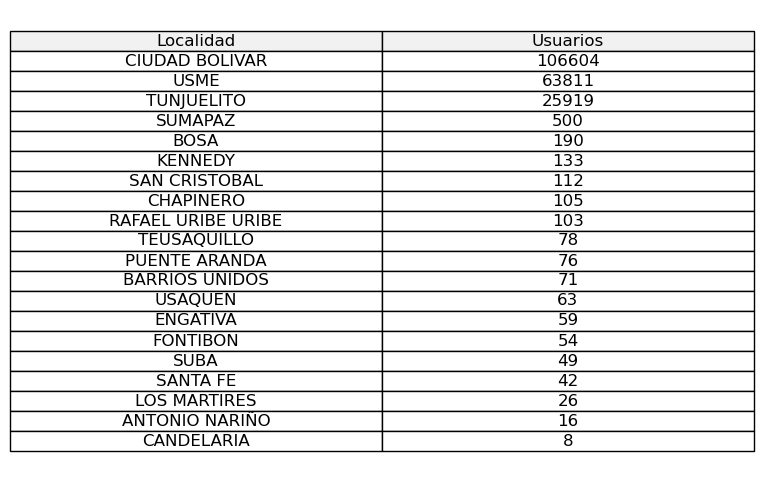

In [87]:
# Crear un DataFrame con los datos
data = {
    "Localidad": usuarios_interes_count.index.tolist() + usuarios_otros_count.index.tolist(),
    "Usuarios": list(usuarios_interes_count.values) + list(usuarios_otros_count.values)
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Desactivar los ejes
ax.axis('tight')
ax.axis('off')

# Crear la tabla con bordes
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f1f1f1"]*2)

# Agregar bordes a las celdas
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(1.2, 1.2)

# Agregar bordes a las celdas de la tabla
for (i, j), cell in tabla.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)

# Mostrar la tabla
plt.show()


**NOTA**

Hasta este punto, se ha mostrado la ubicación de los usuarios asignados para el mes de enero de 2025 en la Subred Sur, según los datos georreferenciados tanto del régimen subsidiado como contributivo. Sin embargo, es necesario verificar si existen datos vacíos o registros sin coordenadas. Esto permitirá continuar con la construcción del código y realizar más operaciones espaciales con datos vectoriales.

**PASO 7-- Encontrar datos vacios , es decir sin coordenadas y elaborar un diagnóstico de los datos**



In [91]:
# Filtrar los registros que tienen coordenadas en 0
usuarios_sin_coordenadas = usuarios_subred_sur[(usuarios_subred_sur['X'] == 0) | (usuarios_subred_sur['Y'] == 0)]

# Contar cuántos registros tienen coordenadas en 0
total_sin_coordenadas = usuarios_sin_coordenadas.shape[0]

# Mostrar el resultado
if total_sin_coordenadas > 0:
    print(f"Cantidad de registros con coordenadas en 0: {total_sin_coordenadas}")
    
    # Ver algunos ejemplos de registros sin coordenadas
    print("\nEjemplo de registros con coordenadas en 0:")
    print(usuarios_sin_coordenadas.head())
else:
    print("No hay registros con coordenadas en 0.")



Cantidad de registros con coordenadas en 0: 20722

Ejemplo de registros con coordenadas en 0:
    ID    X    Y  EDAD SEXO ASEGURAMIENTO
12  13  0.0  0.0    21    F   SUBSIDIADO 
15  16  0.0  0.0    54    M   SUBSIDIADO 
16  17  0.0  0.0    53    M   SUBSIDIADO 
37  38  0.0  0.0    33    F   SUBSIDIADO 
46  47  0.0  0.0    71    M   SUBSIDIADO 


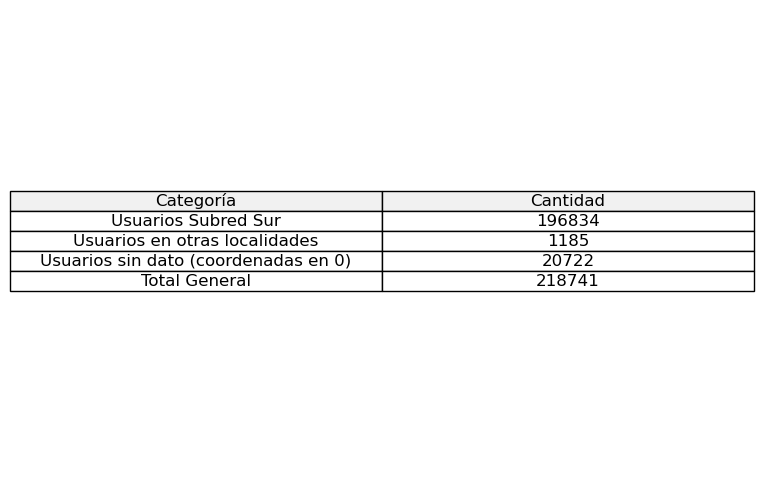

In [105]:
# Datos calculados previamente
usuarios_subred_sur_count = 196834  # Usuarios en Subred Sur
total_usuarios_interes = usuarios_interes_count.sum()  # Usuarios en localidades de interés
total_usuarios_otros = usuarios_otros_count.sum()  # Usuarios en otras localidades
total_sin_coordenadas = usuarios_sin_coordenadas.shape[0]  # Registros con coordenadas en 0
total_general = usuarios_subred_sur_count + total_usuarios_otros + total_sin_coordenadas  # Total general

# Crear la tabla con los resultados
data = {
    "Categoría": ['Usuarios Subred Sur', 'Usuarios en otras localidades', 'Usuarios sin dato (coordenadas en 0)', 'Total General'],
    "Cantidad": [usuarios_subred_sur_count, total_usuarios_otros, total_sin_coordenadas, total_general]
}
df = pd.DataFrame(data)

# Mostrar la tabla
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f1f1f1"]*2)

# Agregar bordes a las celdas
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(1.2, 1.2)

for (i, j), cell in tabla.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)

plt.show()




**DIAGNOSTICO GENERAL USUARIOS ASIGNADOS ENERO 2025 SUBRED SUR**

Según la tabla anterior, se pueden visualizar los resultados de las operaciones espaciales realizadas entre los datos de los usuarios asignados a la Subred Sur y las localidades de la ciudad de Bogotá, utilizando las coordenadas suministradas.

En enero, se registraron 218,741 usuarios. De estos:

89.98% (196,834 usuarios) están ubicados dentro del territorio de la Subred Sur.
0.54% (1,185 usuarios) se encuentran en otras localidades de Bogotá.
9.47% (20,722 usuarios) no poseen coordenadas.

En total, 10.20% (21,907 usuarios) presentan algún problema en la asignación de puntos, lo que puede deberse a la falta de información sobre la dirección o el lugar de residencia de la persona, o a errores en el registro de la dirección.   


**Paso 8-- Localidades de la Subred Sur con los usuarios identificados en el territorio correspondiente**



   ID          X         Y  EDAD SEXO   ASEGURAMIE                   geometry  \
0   1 -74.128344  4.568888    50    F  SUBSIDIADO   POINT (-74.12834 4.56889)   
1   2 -74.128344  4.568888    19    M  SUBSIDIADO   POINT (-74.12834 4.56889)   
2   3 -74.128344  4.568888    23    M  SUBSIDIADO   POINT (-74.12834 4.56889)   
3   4 -74.171004  4.591763    34    F  SUBSIDIADO     POINT (-74.171 4.59176)   
4   5 -74.106723  4.496200    25    M  SUBSIDIADO    POINT (-74.10672 4.4962)   

   index_right       LocNombre           LocAAdmini       LocArea LocCodigo  \
0            1      TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
1            1      TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
2            1      TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
3           14  CIUDAD BOLIVAR   Acuerdo 14 de 1983  1.300026e+08        19   
4           13            USME   Acuerdo 15 de 1993  2.150667e+08        05   

   SHAPE_Leng  SHAPE_Area  
0    0.210

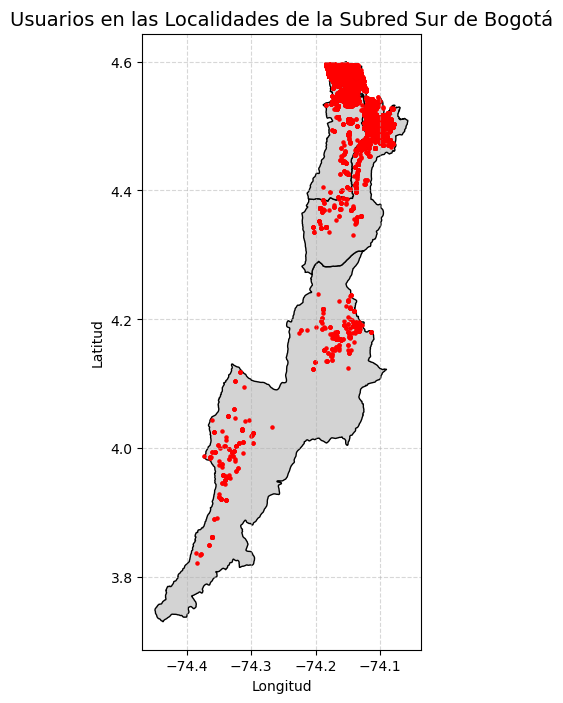

In [141]:
# Filtrar las localidades de interés (Tunjuelito, Sumapaz, Ciudad Bolívar, Usme)
localidades_interes = ['TUNJUELITO', 'SUMAPAZ', 'CIUDAD BOLIVAR', 'USME']
localidades_interes_geo = localidades_bogota[localidades_bogota["LocNombre"].isin(localidades_interes)]

# Reproyectar localidades al CRS de los usuarios (EPSG:4326)
localidades_interes_geo = localidades_interes_geo.to_crs(epsg=4326)

# Realizar la intersección espacial (clip) entre los usuarios y las localidades de la Subred Sur
usuarios_interes_clip = gpd.sjoin(usuarios_subred_sur_geo, localidades_interes_geo, how="inner", predicate="within")

# Ver el resultado
print(usuarios_interes_clip.head())

# Guardar el resultado 
usuarios_interes_clip.to_file(r'C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\usuarios_interes_clip.gpkg', driver="GPKG")

# Crear la visualización
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar las localidades de la Subred Sur
localidades_interes_geo.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1)

# Graficar los puntos de usuarios dentro de las localidades de la Subred Sur 
usuarios_interes_clip.plot(ax=ax, color='red', markersize=5)

# Personalizar el gráfico
ax.set_title("Usuarios en las Localidades de la Subred Sur de Bogotá", fontsize=14)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(True, linestyle="--", alpha=0.5)

# Guardar el mapa en la carpeta 'results'
fig.savefig(r'C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\results\usuarios_interes_clip.png')

# Mostrar el mapa
plt.show()


**Paso 9-- Incluir las unidades de salud disponibles de la Subred Sur** 

Para realizar el análisis de distancia y asignación de los usuarios de la Subred Sur dentro de las cuatro localidades que conforman el territorio, es fundamental considerar las unidades de salud administradas por la entidad. Esto permitirá determinar una distribución adecuada, alineada con la capacidad instalada y el modelo de atención en salud de la ciudad.

In [121]:
# Ruta del archivo CSV
ruta_unidades_salud_Subredsur = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\UNIDADES_SALUD.csv"

# Cargar el archivo y cambiar comas por puntos en los valores numéricos
unidades_salud_df = pd.read_csv(ruta_unidades_salud_Subredsur, sep=";", decimal=",")

# Convertir a GeoDataFrame
unidades_salud_df["geometry"] = unidades_salud_df.apply(lambda row: Point(row["X"], row["Y"]), axis=1)
unidades_salud_gdf = gpd.GeoDataFrame(unidades_salud_df, geometry="geometry", crs="EPSG:4326")  # CRS original

# Reproyectar a EPSG:3395 (Mercator)
unidades_salud_gdf = unidades_salud_gdf.to_crs(epsg=3395)

# Verificar las primeras filas
print(unidades_salud_gdf.head())

# Guardar en un archivo GeoPackage en la carpeta 'data'
unidades_salud_gdf.to_file(r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\unidades_salud_subredsur.gpkg", driver="GPKG")



   FID Shape *  ID                     NOMBRE_DE  \
0    0   Point   1                         TUNAL   
1    1   Point   2                       MEISSEN   
2    2   Point   3  EL CARMEN - MATERNO INFANTIL   
3    3   Point   5                    SAN BENITO   
4    4   Point   8             MANUELA BELTRÁN I   

                          NOMBRE_ACT               TIPOLOGIA  \
0                  HOSPITAL EL TUNAL                HOSPITAL   
1                   HOSPITAL MEISSEN                HOSPITAL   
2  CENTRO DE SALUD EL CARMEN MATERNO  CENTRO DE SALUD TIPO 2   
3         CENTRO DE SALUD SAN BENITO  CENTRO DE SALUD TIPO 2   
4    CENTRO DE SALUD MANUELA BELTRAN  CENTRO DE SALUD TIPO 1   

                   DIRECCION       LOCALIDAD  NOMBRE_UPZ  UPZ          X  \
0           KR 20 47B 35 SUR      TUNJUELITO     VENECIA   42 -74.128232   
1  Cra. 60G No. 18A - 09 Sur  CIUDAD BOLÍVAR      LUCERO   67 -74.138703   
2    CL 48 B SUR No. 28 - 80      TUNJUELITO     VENECIA   42 -74.131871  

**Se muestra el mapa de ubicacion de las unidades en la Subred Sur**

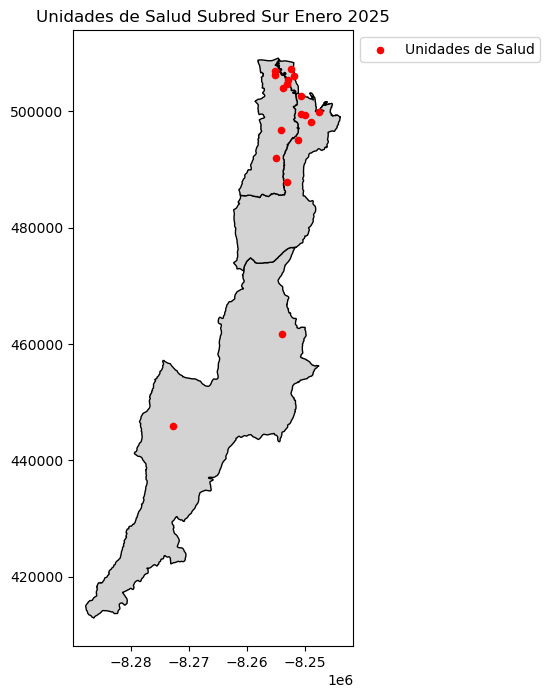

Mapa guardado en: C:/MAESTRIA_EN_GEOMATICA/Programacion_SIG/PROYECTO_FINAL_CODIGO/Analisis_Espacial/results\mapa_localidades_unidades.png


In [127]:
# Las unidades de salud deben tener el mismo CRS que las localidades de la Subred Sur
unidades_salud_gdf = unidades_salud_gdf.to_crs(localidades_interes_geo.crs)

# Crear la figura y el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar las localidades de la Subred Sur
localidades_interes_geo.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1)

# Graficar las unidades de salud (en color rojo)
unidades_salud_gdf.plot(ax=ax, color='red', markersize=20, marker="o", label="Unidades de Salud")

# Ajustar leyenda
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Título del mapa
plt.title("Unidades de Salud Subred Sur Enero 2025")

# Definir la carpeta para guardar la imagen
output_folder = 'C:/MAESTRIA_EN_GEOMATICA/Programacion_SIG/PROYECTO_FINAL_CODIGO/Analisis_Espacial/results'

# Guardar el mapa como imagen con alta resolución
output_path = os.path.join(output_folder, "mapa_localidades_unidades.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")  # Guardar con alta calidad

# Mostrar el mapa en pantalla
plt.show()

# Imprimir la ruta del archivo guardado
print(f"Mapa guardado en: {output_path}")




**Distancia euclidiana**

In [24]:
import osmnx as ox
import networkx as nx
import folium 

Uno de los análisis mas relevantes en los datos referidos a los usuarios asignados en el sistema de salud es el de la asignacion a los centros de salud, para esto , se plantea hallar la distancia mas corta entre la ubicacion de residencia de la persona con respecto a un recinto de salud mas cercano , para esto se usaran las librerias osmnx que da la posibilidad de descargar la información de redes transporte de la gran base de datos geográfica abierta del proyecto OpenStreetMap (OSM) y networkx que es una biblioteca de Python para el estudio de grafos y análisis de redes.

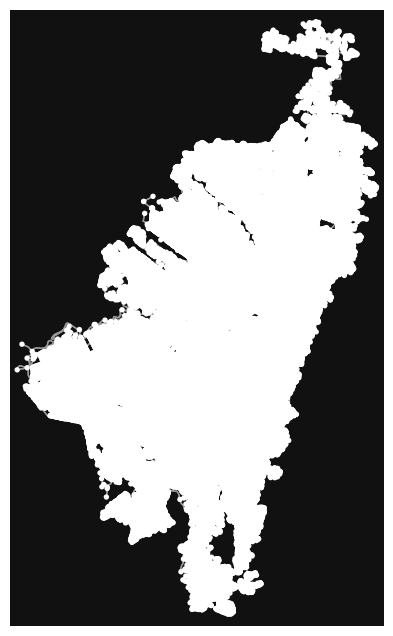

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
#Se identifica la red vial de la ciudad 
ciudad = 'Bogotá, Colombia'
# Descarga la red de calles para la ciudad
Bogota_vias = ox.graph_from_place(ciudad, network_type='all')
#Visualizacion de las vías 
ox.plot_graph(Bogota_vias)

In [53]:
# Definir rutas de los archivos GPKG
ruta_usuarios_gpkg = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\usuarios_interes_clip.gpkg"
ruta_centros_gpkg = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\unidades_salud_subredsur.gpkg"

# Cargar los datos desde los archivos GeoPackage
usuarios_gdf = gpd.read_file(ruta_usuarios_gpkg)
centros_gdf = gpd.read_file(ruta_centros_gpkg)

# Verificar los sistemas de coordenadas
print(f"CRS Usuarios: {usuarios_gdf.crs}, CRS Centros de Salud: {centros_gdf.crs}")

# Transformar ambos a un sistema de coordenadas proyectadas (EPSG:3395) si es necesario
if usuarios_gdf.crs != "EPSG:3395":
    usuarios_gdf = usuarios_gdf.to_crs(epsg=3395)
if centros_gdf.crs != "EPSG:3395":
    centros_gdf = centros_gdf.to_crs(epsg=3395)

# Convertir coordenadas a arrays numpy
usuarios_coords = np.array(list(zip(usuarios_gdf.geometry.x, usuarios_gdf.geometry.y)))
centros_coords = np.array(list(zip(centros_gdf.geometry.x, centros_gdf.geometry.y)))

# Crear un árbol KDTree para optimizar la búsqueda del centro más cercano
tree = cKDTree(centros_coords)

# Encontrar el centro más cercano para cada usuario
distancias, indices = tree.query(usuarios_coords)

# Convertir distancia de metros a kilómetros
distancias_km = distancias / 1000

# Agregar resultados al GeoDataFrame de usuarios
usuarios_gdf["Centro_Salud_Mas_Cercano"] = centros_gdf.iloc[indices]["NOMBRE_ACT"].values
usuarios_gdf["Distancia_Centro_km"] = distancias_km  # Distancia en kilómetros

# Mostrar algunos resultados en consola
print(usuarios_gdf[["Centro_Salud_Mas_Cercano", "Distancia_Centro_km"]].head(10))



CRS Usuarios: EPSG:4326, CRS Centros de Salud: EPSG:3395
              Centro_Salud_Mas_Cercano  Distancia_Centro_km
0                    HOSPITAL EL TUNAL             0.284702
1                    HOSPITAL EL TUNAL             0.284702
2                    HOSPITAL EL TUNAL             0.284702
3  CENTRO DE SALUD CANDELARIA LA NUEVA             2.030673
4           CENTRO DE SALUD LA REFORMA             0.745927
5               HOSPITAL VISTA HERMOSA             1.527447
6           CENTRO DE SALUD LA REFORMA             1.351002
7      CENTRO DE SALUD MANUELA BELTRAN             2.425581
8      CENTRO DE SALUD MANUELA BELTRAN             2.257033
9      CENTRO DE SALUD MANUELA BELTRAN             2.412259


In [45]:
# Definir rutas para guardar los archivos
ruta_salida_csv = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\Distancia_centros.csv"
ruta_salida_gpkg = r"C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\Distancia_centros.gpkg"

# Guardar en CSV
usuarios_gdf[["Centro_Salud_Mas_Cercano", "Distancia_Centro_km"]].to_csv(ruta_salida_csv, index=False)

# Guardar en GPKG
usuarios_gdf.to_file(ruta_salida_gpkg, driver="GPKG")

print("✅ Archivos guardados correctamente:")
print(f"CSV: {ruta_salida_csv}")
print(f"GPKG: {ruta_salida_gpkg}")


✅ Archivos guardados correctamente:
CSV: C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\Distancia_centros.csv
GPKG: C:\MAESTRIA_EN_GEOMATICA\Programacion_SIG\PROYECTO_FINAL_CODIGO\Analisis_Espacial\data\Distancia_centros.gpkg


In [51]:
# Agrupar por centro de salud y calcular la cantidad de usuarios y la distancia promedio
tabla_resumen = usuarios_gdf.groupby("Centro_Salud_Mas_Cercano").agg(
    Poblacion_Asignada=("ID", "count"),
    Distancia_Promedio_km=("Distancia_Centro_km", "mean")
).reset_index()

# Mostrar la tabla
print(tabla_resumen)


               Centro_Salud_Mas_Cercano  Poblacion_Asignada  \
0               CENTRO DE SALUD BETANIA                9787   
1   CENTRO DE SALUD CANDELARIA LA NUEVA               22300   
2          CENTRO DE SALUD DANUBIO AZUL                7668   
3               CENTRO DE SALUD DESTINO                 421   
4     CENTRO DE SALUD EL CARMEN MATERNO               12111   
5              CENTRO DE SALUD LA FLORA                3605   
6            CENTRO DE SALUD LA REFORMA               24432   
7       CENTRO DE SALUD MANUELA BELTRAN               29883   
8            CENTRO DE SALUD MARICHUELA               13322   
9              CENTRO DE SALUD MOCHUELO                1457   
10             CENTRO DE SALUD NAZARETH                 280   
11            CENTRO DE SALUD PASQUILLA                 247   
12           CENTRO DE SALUD SAN BENITO                7520   
13  CENTRO DE SALUD SAN JUAN DE SUMAPAZ                 220   
14                    HOSPITAL EL TUNAL                

**Paso 10-- Densidad poblacional de los usuarios asignados a la Subred Sur**

En este paso, se calculará la densidad de los usuarios asignados a la Subred Sur que se encuentren dentro de las localidades de Tunjuelito, Sumapaz, Ciudad Bolívar y Usme. Para ello, se generará un archivo raster, que permite estimar la concentración de puntos en el espacio y visualizar las zonas con mayor y menor presencia de usuarios. 

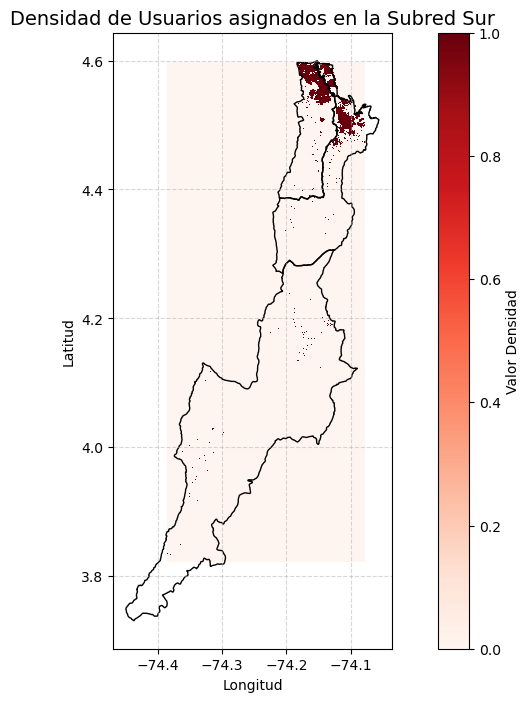

In [143]:
# Cargar el GeoDataFrame de localidades
localidades_interes = ['TUNJUELITO', 'SUMAPAZ', 'CIUDAD BOLIVAR', 'USME']
localidades_bogota = gpd.read_file('C:/MAESTRIA_EN_GEOMATICA/Programacion_SIG/PROYECTO_FINAL_CODIGO/Analisis_Espacial/data/Loca.shp')  # Ruta correcta

# Filtrar las localidades de interés
localidades_interes_geo = localidades_bogota[localidades_bogota["LocNombre"].isin(localidades_interes)]

# Asegurarse de que las coordenadas de los usuarios están en el mismo CRS que las localidades
usuarios_interes_clip = usuarios_interes_clip.to_crs(localidades_interes_geo.crs)

# Definir la resolución del raster (en este caso, 100 metros por celda)
raster_resolution = 0.001  # Puede ajustarse según el tamaño del área

# Obtener los límites de la geometría de los usuarios
xmin, ymin, xmax, ymax = usuarios_interes_clip.total_bounds

# Crear una cuadrícula para el raster con resolución ajustada usando np.linspace
x = np.linspace(xmin, xmax, int((xmax - xmin) / raster_resolution))  # Crear  un número adecuado de puntos
y = np.linspace(ymin, ymax, int((ymax - ymin) / raster_resolution))  # Crear  un número adecuado de puntos

# Crear malla de coordenadas
grid = np.meshgrid(x, y)

# Obtener las coordenadas de los usuarios y crear geometrías de puntos
usuarios_points = [Point(xy) for xy in zip(usuarios_interes_clip['X'], usuarios_interes_clip['Y'])]

# Crear una máscara para los puntos en el raster
shapes = [(point, 1) for point in usuarios_points]

# Crear el raster de densidad de usuarios
raster = rasterize(shapes, out_shape=(len(y)-1, len(x)-1), transform=rasterio.transform.from_origin(xmin, ymax, raster_resolution, raster_resolution))

# Guardar el raster de densidad
raster_output_path = 'C:/MAESTRIA_EN_GEOMATICA/Programacion_SIG/PROYECTO_FINAL_CODIGO/Analisis_Espacial/data/densidad_usuarios.tif'

with rasterio.open(raster_output_path, 
                   'w', 
                   driver='GTiff',
                   height=raster.shape[0],
                   width=raster.shape[1],
                   count=1,
                   dtype=rasterio.float32,
                   crs=localidades_interes_geo.crs,
                   transform=rasterio.transform.from_origin(xmin, ymax, raster_resolution, raster_resolution)) as dst:
    dst.write(raster, 1)

# Crear la visualización
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar el raster de densidad de usuarios con la paleta 'Reds'
cax = ax.imshow(raster, cmap='Reds', interpolation='nearest', origin='upper', extent=(xmin, xmax, ymin, ymax))

# Graficar las localidades
localidades_interes_geo.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Añadir barra de color
cbar = plt.colorbar(cax, ax=ax, label='Valor Densidad')

# Personalizar el gráfico
ax.set_title('Densidad de Usuarios asignados en la Subred Sur', fontsize=14)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True, linestyle="--", alpha=0.5)

# Guardar el mapa 
map_output_path = 'C:/MAESTRIA_EN_GEOMATICA/Programacion_SIG/PROYECTO_FINAL_CODIGO/Analisis_Espacial/results/densidad_usuarios_mapa.png'

# Guardar el mapa con alta resolución
plt.savefig(map_output_path, dpi=300, bbox_inches='tight')

# Mostrar el mapa
plt.show()










Con el la union hecha entre los usuarios asignados que en sus coordenadas se ubicaron en la Subred Sur y las localidades que componen la entidad, se desarrolla un archivo raster general en el cual se visualiza la concentración de las personas que estan en la Subred Integrada de Servicios Sur, dada la extension del territorio se debe realizar este proceso en unidades territoriales mas pequeñas (sea localidad , UPZ, UPR u otro) , en este ejercicio se pasara a otro analisis en relación a la asignacion de usuarios a los centros de salud  